### Human Segmentation Practice Project

Dataset can be found at https://github.com/VikramShenoy97/Human-Segmentation-Dataset <br></br>
Dataset has 2 images, one of the original image and one of the ground truth

<img src="u-net-architecture.png" width="25%" height="25%">

U-net-architecture will be used where the input image will be of size IMAGE_SIZE and output segmentation image will be of size IMAGE_SIZE.

#### Setting Up

Terminal commands: <br></br>
pip install segmentation-models-pytorch <br></br>
pip install -U git+https://github.com/albumentations-team/albumentations <br></br>
pip install --upgrade opencv-contrib-python <br></br>
git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git <br></br>

In [1]:
# Imports
import sys
sys.path.append('/Human-Segmentation-Dataset-master')

import torch 
import cv2

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from tqdm import tqdm
import albumentations as A
from torch.utils.data import Dataset

from torch.utils.data import DataLoader


C:\Users\sarmi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
CSV_FILE = 'S:/Github/Data-Science/Projects/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR = 'S:/Github/Data-Science/Projects/'

# using gpu
DEVICE = 'cpu'

#Hyperparameters
EPOCHS = 25
LR = 0.003
IMAGE_SIZE = 320
BATCH_SIZE = 16

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [3]:
df = pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


Training data consist of image and its correspoding mask for each row/observation

#### Data Visualization

In [4]:
observation = df.iloc[2]

image_path = observation.images
mask_path = observation.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0 # normalize image

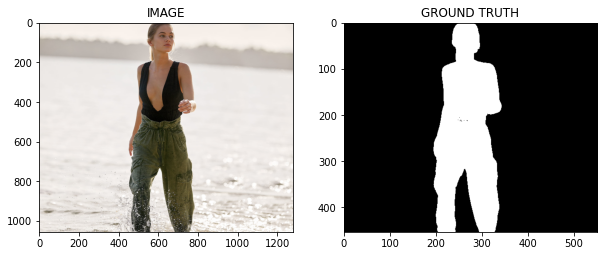

In [5]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [6]:
# split data
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)

#### Data Augmentation

In [7]:
def get_train_augs():
  return A.Compose([
                    # A.Resize(IMAGE_SIZE, IMAGE_SIZE),
                    A.HorizontalFlip(p=0.5),  # p chance of flip
                    A.VerticalFlip(p=0.5)
  ])

# def get_valid_augs():
#   return A.Compose([
#                     A.Resize(IMAGE_SIZE, IMAGE_SIZE)
#   ])


#### Custom Dataset w/ Augmentation

In [8]:
class SegmentationDataset(Dataset):
  def __init__(self, df, augmentations):
    self.df = df
    self.augmentations = augmentations
  
  def __len__(self):
    return len(self.df)
  
  def __getitem__(self, index):
    row = self.df.iloc[index]
    
    image_path = row.images
    mask_path = row.masks

    image = cv2.imread(image_path)
    image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # curent shape  (h, w)
    mask = cv2.resize(mask, (IMAGE_SIZE, IMAGE_SIZE))
    mask = np.expand_dims(mask, axis=-1)  # convert to shape  (h, w, c) w/ c as 1(grayscale)

    if self.augmentations:
      data = self.augmentations(image=image, mask=mask) # return as dictionary
      image = data.get('image')
      mask = data.get('mask')

    # (h, w, c) -> (c, h, w) since we use PyTorch
    image = np.transpose(image, (2, 0, 1)).astype(np.float32) 
    mask = np.transpose(mask, (2, 0, 1)).astype(np.float32)

    # convert to Tensor
    image = torch.Tensor(image) / 255.0
    mask = torch.round(torch.Tensor(mask) / 255.0) 

    return image, mask

In [9]:
trainset = SegmentationDataset(train_df, get_train_augs())
# validset = SegmentationDataset(valid_df, get_valid_augs())
# trainset = SegmentationDataset(train_df, augmentations=None)
validset = SegmentationDataset(valid_df, augmentations=None)

In [10]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


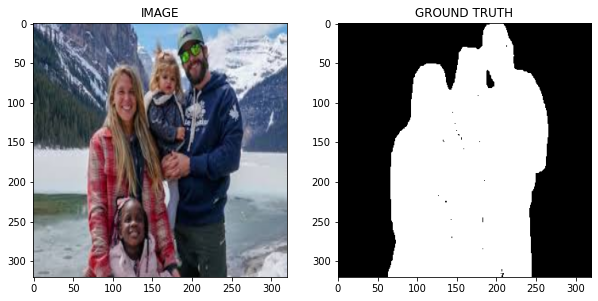

In [11]:
import helper
idx = 2

image, mask= trainset[idx]
helper.show_image(image, mask)

In [12]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE)

In [13]:
print(f'total no. of batches in trainloader : {len(trainloader)}')
print(f'total no. of batches in validloader : {len(validloader)}')

total no. of batches in trainloader : 15
total no. of batches in validloader : 4


In [14]:
for image, mask in trainloader:
  break

print(f'One batch image shape : {image.shape}')
print(f'One batch mask shape : {mask.shape}')

One batch image shape : torch.Size([16, 3, 320, 320])
One batch mask shape : torch.Size([16, 1, 320, 320])


#### Create Model

Documentation for segmentation model https://smp.readthedocs.io/en/latest/

In [15]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss #Loss function

In [16]:
class SegmentationModel(nn.Module):
  def __init__(self) -> None:
      super(SegmentationModel, self).__init__() # usually do this to create model in Pytorch

      self.arc = smp.Unet(
          encoder_name=ENCODER, # 'timm-efficientnet-b0'
          encoder_weights=WEIGHTS, # 'imagenet'
          in_channels=3, # RGB
          classes=1, # Binary
          activation=None # output logits will be raw, 
      )
    
  def forward(self, images, masks=None):
    logits = self.arc(images)

    if masks != None: # must use != else does not run in training: "Boolean value of Tensor with more than one value is ambiguous"
      loss1 = DiceLoss(mode='binary')(logits, masks) # comparing mask generated from model vs ground truth to generate loss
      loss2 = nn.BCEWithLogitsLoss()(logits, masks) 
      return logits, loss1 + loss2
    
    return logits

In [17]:
model = SegmentationModel()
model.to(DEVICE)

SegmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
           

In [18]:
print(torch.cuda.is_available()) 

False


In [19]:
def train_fn(data_loader: DataLoader, model: SegmentationModel, optimizer):
  model.train()
  total_loss = 0.0

  for images, masks in tqdm(data_loader):
    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()
    logits, loss = model(images, masks)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
  
  return total_loss / len(data_loader)

In [20]:
def eval_fn(data_loader: DataLoader, model: SegmentationModel):
  model.eval()
  total_loss = 0.0

  with torch.no_grad():
    for images, masks in tqdm(data_loader):
      images = images.to(DEVICE)
      masks = masks.to(DEVICE)

      logits, loss = model(images, masks)

      total_loss += loss.item()
  
    return total_loss / len(data_loader)

In [21]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [22]:
best_valid_loss = np.Inf

for i in range(EPOCHS):
  train_loss = train_fn(trainloader, model, optimizer)
  valid_loss = eval_fn(validloader, model)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt') # .pt = pytorch
    print('SAVED-MODEL')
    best_valid_loss = valid_loss

  print(f'Epoch: {i+1} Train_loss: {train_loss} Valid_loss: {valid_loss}')

100%|██████████| 4/4 [00:06<00:00,  1.74s/it]


SAVED-MODEL
Epoch: 1 Train_loss: 0.6940173228581746 Valid_loss: 4.7058573961257935


100%|██████████| 4/4 [00:06<00:00,  1.65s/it]


SAVED-MODEL
Epoch: 2 Train_loss: 0.39313733180363974 Valid_loss: 0.4665863513946533


100%|██████████| 4/4 [00:06<00:00,  1.67s/it]


SAVED-MODEL
Epoch: 3 Train_loss: 0.2911699334780375 Valid_loss: 0.25150394439697266


100%|██████████| 4/4 [00:06<00:00,  1.64s/it]


Epoch: 4 Train_loss: 0.28052570422490436 Valid_loss: 0.2627325616776943


100%|██████████| 4/4 [00:06<00:00,  1.65s/it]


Epoch: 5 Train_loss: 0.22904858191808064 Valid_loss: 0.27324913442134857


100%|██████████| 4/4 [00:06<00:00,  1.69s/it]


SAVED-MODEL
Epoch: 6 Train_loss: 0.2256760388612747 Valid_loss: 0.2335875928401947


100%|██████████| 4/4 [00:06<00:00,  1.67s/it]


Epoch: 7 Train_loss: 0.19216264535983404 Valid_loss: 0.24153278023004532


100%|██████████| 4/4 [00:06<00:00,  1.67s/it]


Epoch: 8 Train_loss: 0.21023737788200378 Valid_loss: 0.23457997664809227


100%|██████████| 4/4 [00:06<00:00,  1.66s/it]


SAVED-MODEL
Epoch: 9 Train_loss: 0.18826967974503836 Valid_loss: 0.21886559017002583


100%|██████████| 4/4 [00:06<00:00,  1.71s/it]


SAVED-MODEL
Epoch: 10 Train_loss: 0.1473717873295148 Valid_loss: 0.19602786377072334


100%|██████████| 4/4 [00:06<00:00,  1.75s/it]


SAVED-MODEL
Epoch: 11 Train_loss: 0.14651409834623336 Valid_loss: 0.19498445466160774


100%|██████████| 4/4 [00:06<00:00,  1.73s/it]


Epoch: 12 Train_loss: 0.17972384492556254 Valid_loss: 0.24361078441143036


100%|██████████| 4/4 [00:07<00:00,  1.76s/it]


Epoch: 13 Train_loss: 0.2136483371257782 Valid_loss: 0.2319636307656765


100%|██████████| 4/4 [00:07<00:00,  1.80s/it]


Epoch: 14 Train_loss: 0.22801157236099243 Valid_loss: 0.2501034513115883


100%|██████████| 4/4 [00:06<00:00,  1.70s/it]


Epoch: 15 Train_loss: 0.17718419879674913 Valid_loss: 0.21675138920545578


100%|██████████| 4/4 [00:06<00:00,  1.71s/it]


SAVED-MODEL
Epoch: 16 Train_loss: 0.1545122057199478 Valid_loss: 0.18713920935988426


100%|██████████| 4/4 [00:06<00:00,  1.68s/it]


SAVED-MODEL
Epoch: 17 Train_loss: 0.18579869170983632 Valid_loss: 0.18613400869071484


100%|██████████| 4/4 [00:06<00:00,  1.65s/it]


SAVED-MODEL
Epoch: 18 Train_loss: 0.14982882440090178 Valid_loss: 0.18176798708736897


100%|██████████| 4/4 [00:06<00:00,  1.68s/it]


Epoch: 19 Train_loss: 0.12787057211001715 Valid_loss: 0.19159795343875885


100%|██████████| 4/4 [00:06<00:00,  1.67s/it]


SAVED-MODEL
Epoch: 20 Train_loss: 0.11194198230902354 Valid_loss: 0.1715700402855873


100%|██████████| 4/4 [00:06<00:00,  1.66s/it]


SAVED-MODEL
Epoch: 21 Train_loss: 0.10568992743889491 Valid_loss: 0.1633875947445631


100%|██████████| 4/4 [00:06<00:00,  1.67s/it]


Epoch: 22 Train_loss: 0.09250406871239344 Valid_loss: 0.17582682147622108


100%|██████████| 4/4 [00:06<00:00,  1.71s/it]


SAVED-MODEL
Epoch: 23 Train_loss: 0.09375780820846558 Valid_loss: 0.1555542964488268


100%|██████████| 4/4 [00:06<00:00,  1.67s/it]


Epoch: 24 Train_loss: 0.0874142882724603 Valid_loss: 0.18781769648194313


100%|██████████| 4/4 [00:06<00:00,  1.67s/it]

Epoch: 25 Train_loss: 0.09225392068425814 Valid_loss: 0.19744007103145123


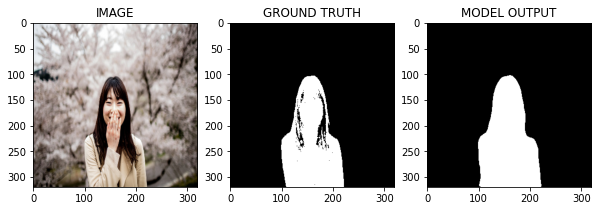

In [71]:
idx = 25

model.load_state_dict(torch.load('S:/Github/Data-Science/Projects/best_model.pt'))

image, mask = validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze (0))  # (C, H, W) -> (1, C, H, W) where 1 is batch size just to use sigmoid
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5) * 1.0
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0)) # convert back (1, C, H, W) -> (C, H, W)